In [1]:
import pandas as pd
import numpy as np 
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler , PowerTransformer 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering,SpectralClustering
from sklearn.metrics import silhouette_samples , silhouette_score 
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly_express as px
import pylab
%matplotlib inline
%run '/home/vinicius_ota/Área de Trabalho/python_functions/connect_dw.py'






params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Função pré processamento

In [2]:
def preprocessing_feature( data , scaler_type  ):
    if scaler_type == 'StandarScaler': 
        std = StandardScaler().fit_transform( data )
        return pd.DataFrame(StandardScaler().fit_transform( data ) , columns = data.columns)
    if scaler_type == 'RobustScaler': 
        return pd.DataFrame(RobustScaler().fit_transform( data ) , columns = data.columns) 
    if scaler_type == 'MinMaxScaler': 
        return pd.DataFrame(MinMaxScaler().fit_transform( data ) , columns = data.columns)
    if scaler_type == 'Power': 
        return pd.DataFrame(PowerTransformer(method='box-cox').fit_transform(data) , columns = data.columns)

In [3]:
def percentilValues(DataSet,percentil,feature):
    value=DataSet[feature].quantile(percentil)
    return percentil,value

## Importando dados 

In [4]:
data = pd.read_sql_query("""SELECT 
                            nr_carteirinha ,
                            (max(dt_autorizacao::date) - min(dt_autorizacao::date)) AS tempo_entre_consultas,
                            current_date::date - max(dt_autorizacao::date) AS recencia,
                            count(DISTINCT nr_guia ) AS quantidade_guias,
                            sum(vl_unit_proced_guia*qt_proced_autorizado) AS sinistro_total
                        FROM  mv_data.invoices i 
                        WHERE status_guia = 'AUTORIZADA'
                        GROUP BY 1""", 
                         con=get_engine())

## Analise percentil

In [5]:
percentil_value, percentil = zip(*[
    percentilValues(DataSet=data, feature='sinistro_total', percentil=value)
    for value in np.arange(0, 1, 0.03)
])
DataPercentil = pd.DataFrame(zip(percentil_value,percentil),columns=['percentil','value'])

In [6]:
DataPercentil

,percentil,value
0,0.00,0.0100
1,0.03,0.0100
2,0.06,0.0300
3,0.09,50.0100
4,0.12,80.0000
5,0.15,80.0000
6,0.18,80.0100
7,0.21,80.0100
8,0.24,80.0300
9,0.27,125.0426


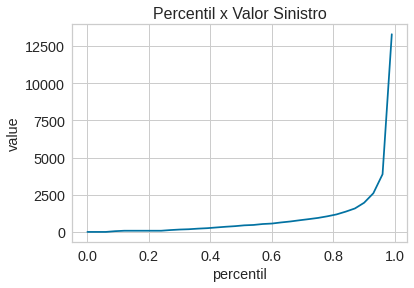

In [7]:
sns.lineplot(data=DataPercentil,x='percentil',y='value')
plt.title('Percentil x Valor Sinistro',fontsize=16) ;  

## Criando dataset com sinistros dentro do percentil 0.96

In [8]:
cut=DataPercentil[DataPercentil['percentil']==0.96]
DataCluster = data[data['sinistro_total']<=cut.iloc[0][1]]
DataCluster = DataCluster[DataCluster['nr_carteirinha']!='5462110010001001572']

## Elbow Plot por Padronização

In [9]:
list_scaler = []
list_ncluster = []
list_inertia = []
for i in ['StandarScaler', 'RobustScaler', 'MinMaxScaler']:
    for j in np.arange(1, 10):
        # Ajustando kmeans
        fit_kmeans = KMeans(n_clusters=j).fit(
            preprocessing_feature(DataCluster.drop(['nr_carteirinha'], axis=1), i))
        # Validar se isso está no lugar correto:
        list_inertia.append(fit_kmeans.inertia_)
        list_ncluster.append(j)
        list_scaler.append(i)
WcssData = pd.DataFrame(list(zip(list_inertia, list_ncluster, list_scaler)), columns=[
                        'inertia', 'ncluster', 'preprocessing'])

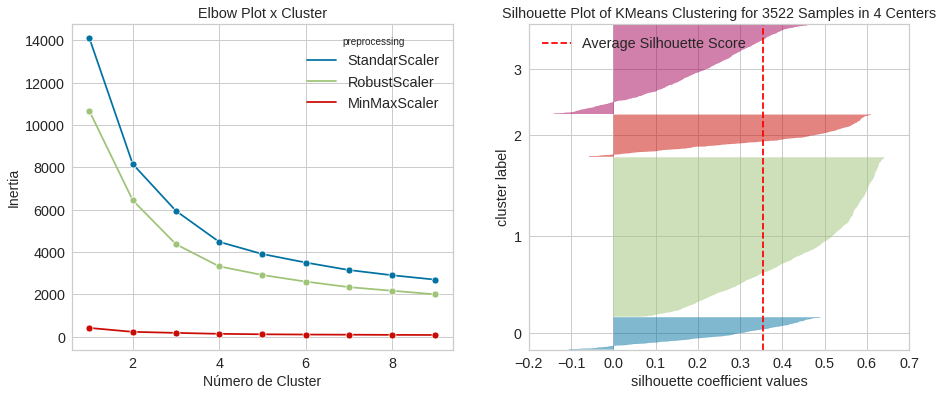

In [10]:
plt.figure(figsize=(15,6))

plt.subplot(121)
sns.lineplot(data=WcssData, 
             x='ncluster', 
             y='inertia', 
             hue='preprocessing',
             marker='o') 
plt.title("Elbow Plot x Cluster") 
plt.xlabel("Número de Cluster",fontsize=14) 
plt.ylabel("Inertia",fontsize=14) 

plt.subplot(122)
silhouette_visualizer(KMeans(4, random_state=123),
                      X=preprocessing_feature(DataCluster, 'RobustScaler'),
                      colors='yellowbrick') ;


## Ajustando Kmeans

In [11]:
def preprocessing_feature( data , scaler_type  ):
    if scaler_type == 'StandarScaler': 
        std = StandardScaler().fit_transform( data )
        return pd.DataFrame(StandardScaler().fit_transform( data ) , columns = data.columns)
    if scaler_type == 'RobustScaler': 
        return pd.DataFrame(RobustScaler().fit_transform( data ) , columns = data.columns) 
    if scaler_type == 'MinMaxScaler': 
        return pd.DataFrame(MinMaxScaler().fit_transform( data ) , columns = data.columns)
    if scaler_type == 'Power': 
        return pd.DataFrame(PowerTransformer(method='box-cox').fit_transform(data) , columns = data.columns)

fitKmeans = KMeans(n_clusters=3).fit(preprocessing_feature(DataCluster,'RobustScaler'))
DataCluster['kmeans_cluster'] = pd.Series(fitKmeans.labels_, index=DataCluster.index)
DataCluster['kmeans_cluster'] = DataCluster['kmeans_cluster'].map({0:'A',1:'B',2:'C'})

In [16]:
DataCluster.to_sql(name='cluster_rfm',schema='sandbox',index=False,con = get_engine(),method='multi')

## Densidade de sinistro por cluster

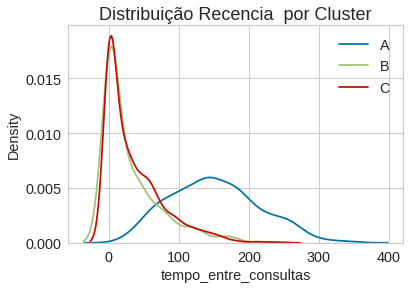

In [13]:
fig, ax = plt.subplots() ;
for cluster in ['A','B','C']:
    sns.kdeplot(DataCluster[DataCluster['kmeans_cluster']==cluster]['tempo_entre_consultas'], ax=ax , label=cluster) 
plt.legend() 
plt.title('Distribuição Recencia  por Cluster',fontsize = 18); 


## Recencia e Sinistro

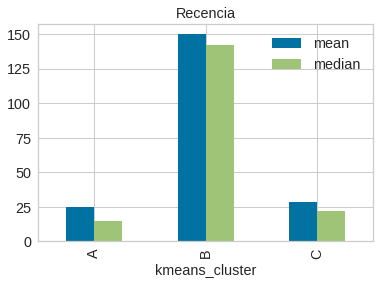

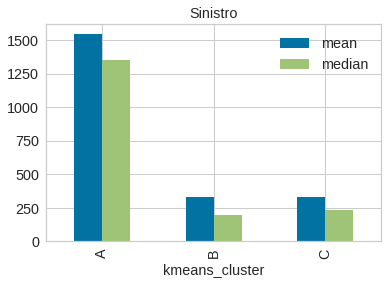

In [14]:
def PlotByStatistics(Data,groupVariable,descVariable,dict_statistics):
    DataGroup = Data.groupby(groupVariable)[descVariable].agg(dict_statistics).reset_index()
    DataGroup.plot(x=groupVariable,y=list(dict_statistics),kind='bar')



PlotByStatistics(Data=DataCluster,groupVariable='kmeans_cluster',descVariable='recencia',dict_statistics={'mean','median'})
plt.title('Recencia')
PlotByStatistics(Data=DataCluster,groupVariable='kmeans_cluster',descVariable='sinistro_total',dict_statistics={'mean','median'})
plt.title('Sinistro') ; 